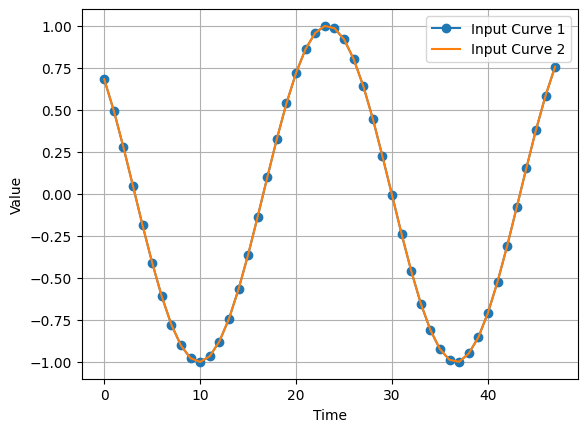

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.optimize import linear_sum_assignment

# torch.manual_seed(0)

# -------------------------------
# Synthetic Data Generator
# -------------------------------
def generate_data(seq_length, num_samples, offset=0.0, N_curves=2):
    X, Y = [], []
    for _ in range(num_samples):
        t = np.linspace(0, 2 * np.pi, seq_length)
        curves = []
        for i in range(N_curves):
            freq = np.random.uniform(0.5, 2.0)
            phase = np.random.uniform(0, 2 * np.pi)
            curve = np.sin(freq * t + phase) + i*offset + 0.001 * np.random.randn(seq_length)
            curves.append(curve)
        seq = np.stack(curves, axis=-1)  # shape: (seq_length, N_)
        X.append(seq[:-1])
        Y.append(seq[1:])
    
    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32)
    return X, Y

# -------------------------------
# Custom Dataset for Time-Series Data
# -------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # shape: (num_samples, seq_len, N_curves)
        self.Y = Y  # shape: (num_samples, seq_len, N_curves)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
# Parameters
N_curves = 2
seq_length = 50
num_samples = 100
offset = 1.0

X_train, Y_train = generate_data(seq_length, num_samples, offset=offset) # shape: (num_samples, seq_length-1, N_curves)
plt.plot(X_train[0, 1:, 0].numpy(), label='Input Curve 1', marker='o')
plt.plot(Y_train[0, :-1, 0].numpy(), label='Input Curve 2')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

DataLoader Shuffling Check:


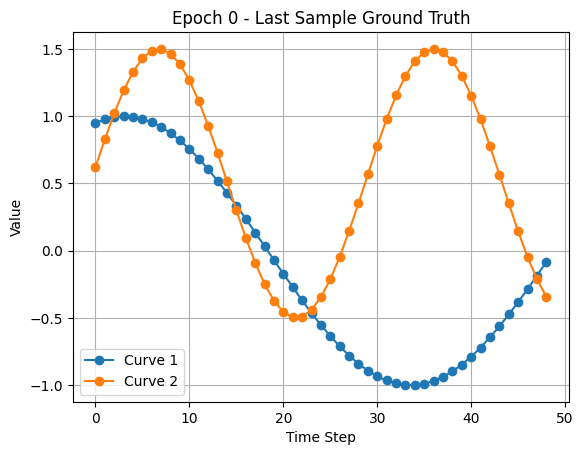

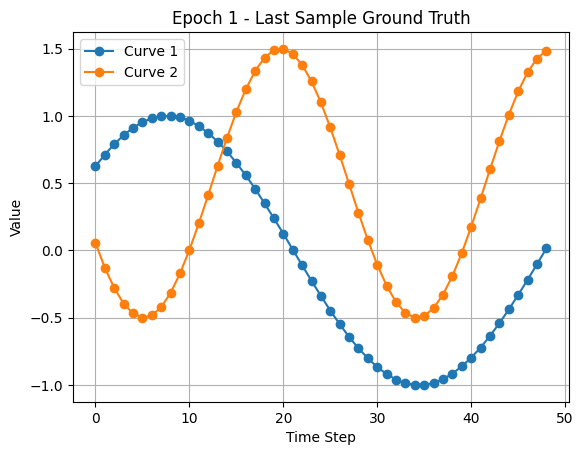

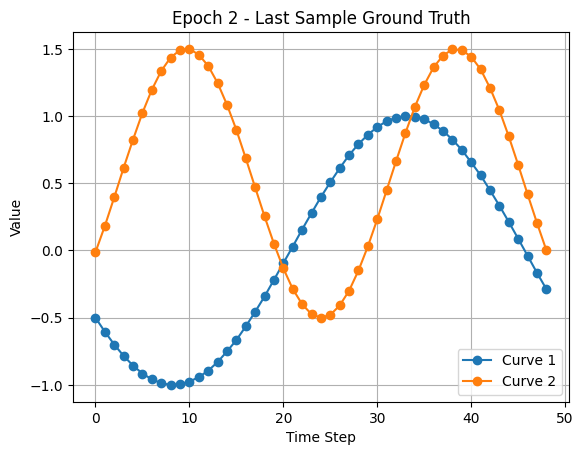

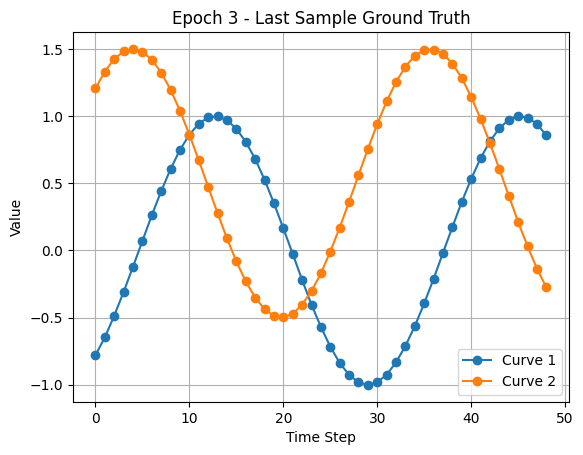

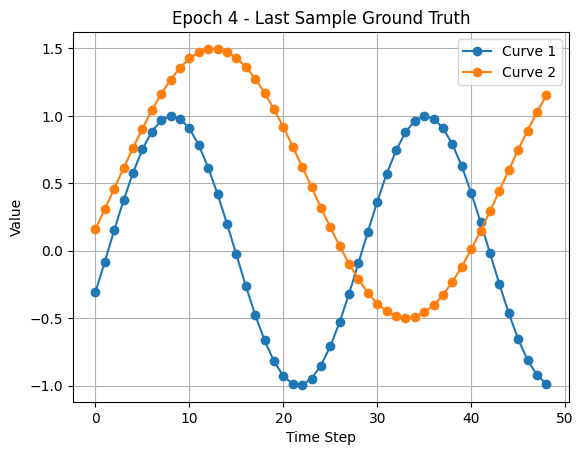

In [2]:
# -------------------------------
# Parameters and DataLoader Setup
# -------------------------------
seq_length = 50
num_samples = 10  # Reduced number of samples
offset = 0.5
N_curves = 2

X, Y = generate_data(seq_length, num_samples, offset=offset, N_curves=N_curves)
dataset = TimeSeriesDataset(X, Y)
batch_size = 3  # Reduced batch size

# DataLoader with shuffle=True ensures a different order each epoch.
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# Check Shuffling Over Epochs
# -------------------------------
num_epochs = 5
print("DataLoader Shuffling Check:")
for epoch in range(num_epochs):
    last_sample_ground_truth = None
    # Iterate over the DataLoader for this epoch
    for X_batch, Y_batch in train_loader:
        # Store the ground truth from the last sample in the current batch
        # Here we use the input sequence (X_batch) as the ground truth to plot.
        last_sample_ground_truth = X_batch[-1]
    
    # After iterating over all batches, plot the ground truth of the last sample.
    # (It will be different each epoch if shuffling works as expected.)
    plt.figure()
    # last_sample_ground_truth shape: (seq_length-1, N_curves)
    plt.plot(last_sample_ground_truth[:, 0].numpy(), label='Curve 1', marker='o')
    plt.plot(last_sample_ground_truth[:, 1].numpy(), label='Curve 2', marker='o')
    plt.title(f"Epoch {epoch} - Last Sample Ground Truth")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:

# -------------------------------
# Linear RNN Model
# -------------------------------
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # Using batch_first=True, so input and output are (batch, seq_len, feature)
        self.rnn = nn.RNN(input_size, hidden_size, bias=True, batch_first=True, nonlinearity='tanh')
        self.output_layer = nn.Linear(hidden_size, output_size, bias=True)
    
    def forward(self, measurement, hidden):
        # measurement: expected shape (batch, input_size)
        # Unsqueeze to get shape (batch, 1, input_size)
        if measurement.dim() == 2:
            measurement = measurement.unsqueeze(1)
        output_seq, hidden_new = self.rnn(measurement, hidden)
        # Use the last hidden state for prediction; shape: (batch, hidden_size)
        prediction = self.output_layer(hidden_new[-1])
        return prediction, hidden_new

    def init_hidden(self, batch_size=1):
        # Hidden shape: (num_layers, batch, hidden_size)
        return torch.zeros(1, batch_size, self.hidden_size)


In [4]:
# -------------------------------
# Hyperparameters and Data Preparation
# -------------------------------
N_curves = 4
seq_length = 50         # Total length of the full sine curve sequence
num_samples = 200
offset = 1.0

input_size = N_curves
hidden_size = 2 * N_curves
output_size = 2 * N_curves
num_epochs = 250
lr = 0.01
batch_size = 32

# Generate synthetic data
X_all, Y_all = generate_data(seq_length, num_samples, offset=offset, N_curves=N_curves)
# X_all, Y_all shape: (num_samples, seq_length-1, N_curves)
# Create full dataset and then split into train and test sets (80/20 split)
full_dataset = TimeSeriesDataset(X_all, Y_all)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# Model, Loss, Optimizer, and Prediction Matrix
# -------------------------------
model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

lambda_smooth = 0.1  # hyperparameter to control the weight of the smoothness penalty

# Prediction matrix for Hungarian assignment:
# Maps hidden state to predicted positions.
pred_mat = torch.zeros((N_curves, hidden_size))
pred_mat[:N_curves, :N_curves] = torch.eye(N_curves) * 2
pred_mat[:, N_curves:] = -torch.eye(N_curves)

Epoch 0, Train Loss: 3.292187, Test MSE: 2.615430, Test Smooth: 0.072204


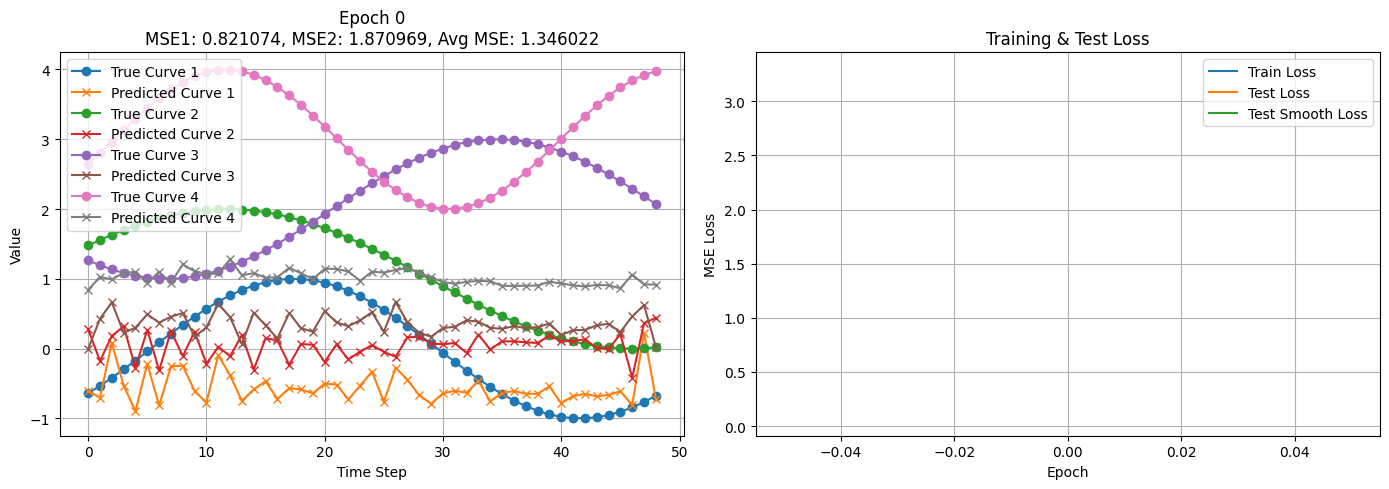

Epoch 20, Train Loss: 0.383366, Test MSE: 0.367776, Test Smooth: 0.012846


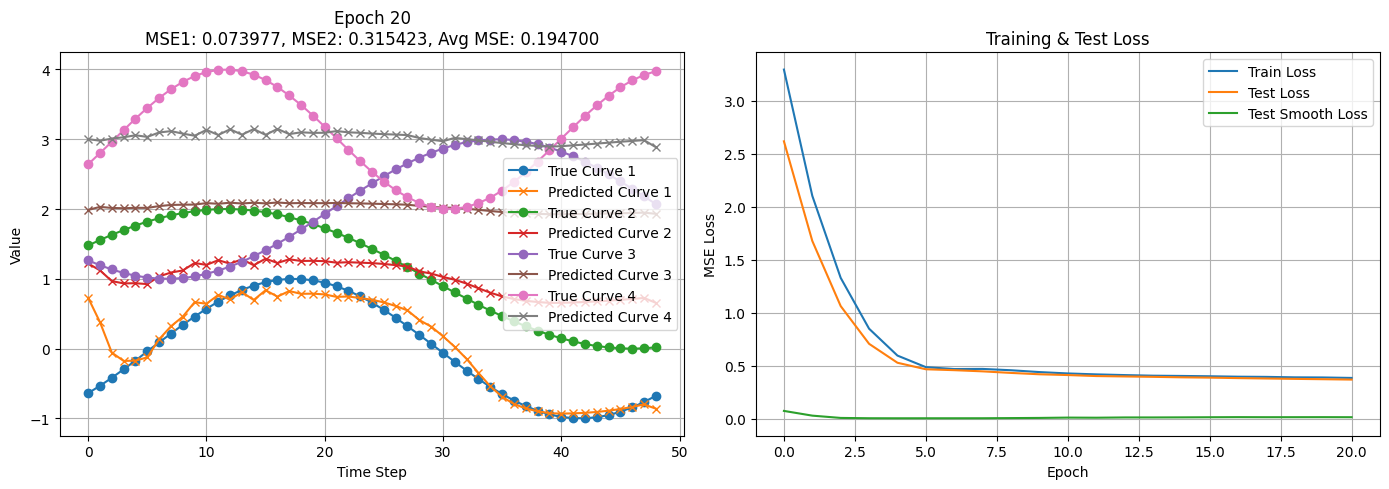

Epoch 40, Train Loss: 0.297184, Test MSE: 0.282533, Test Smooth: 0.018006


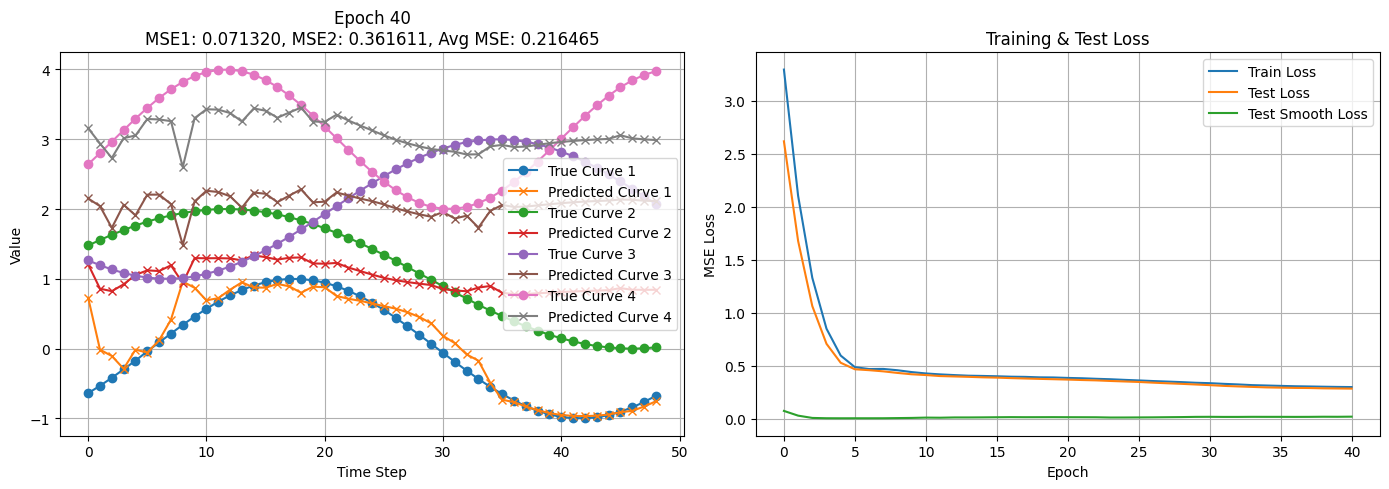

Epoch 60, Train Loss: 0.289956, Test MSE: 0.277591, Test Smooth: 0.031856


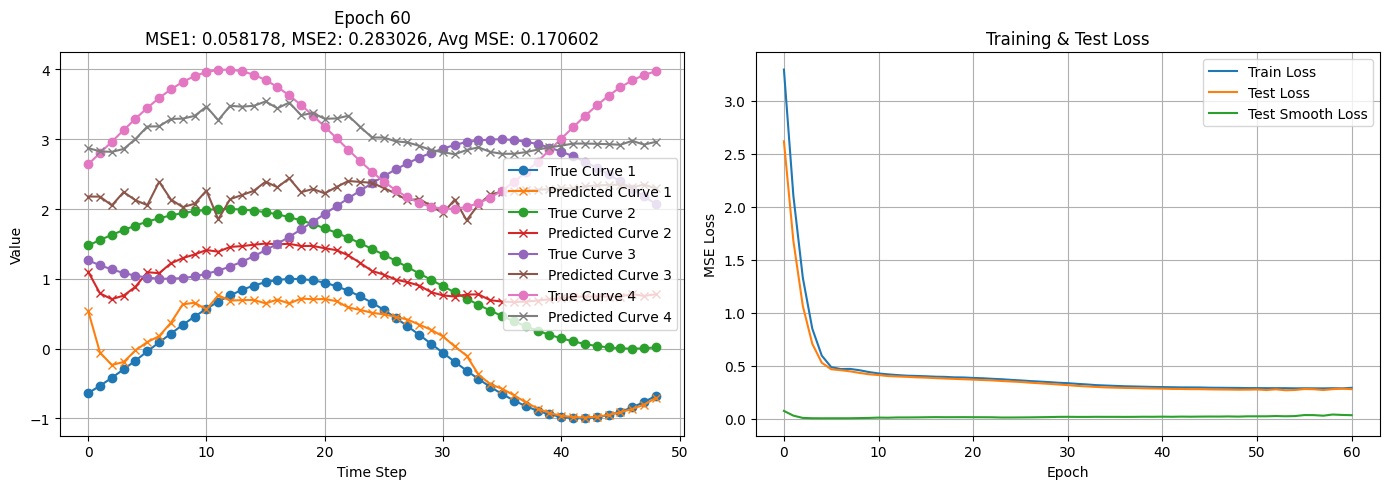

Epoch 80, Train Loss: 0.276404, Test MSE: 0.255035, Test Smooth: 0.041818


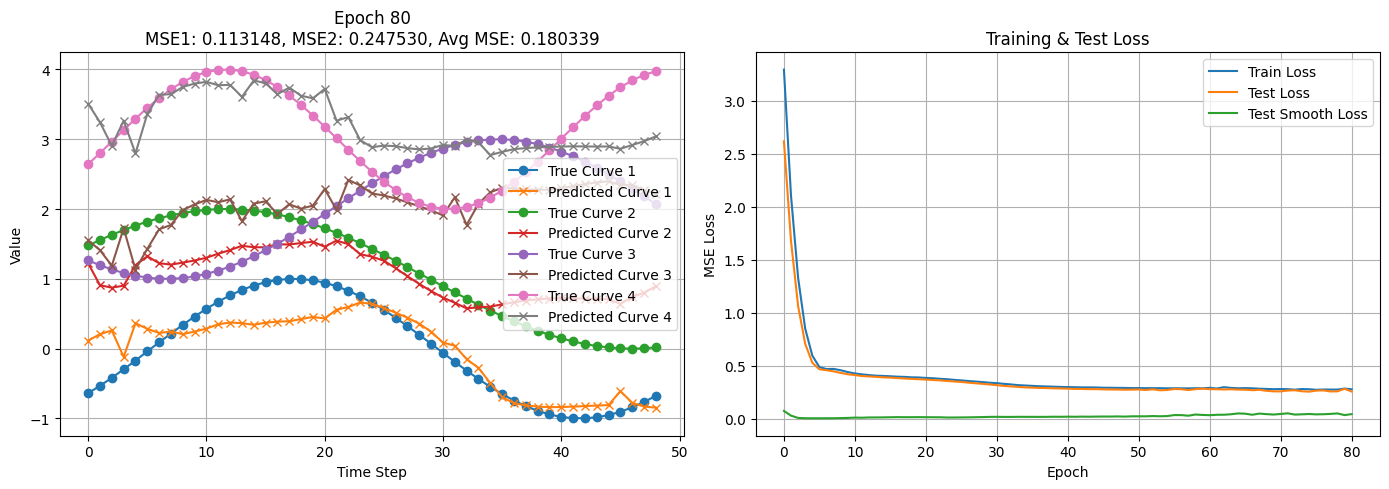

Epoch 100, Train Loss: 0.277795, Test MSE: 0.259793, Test Smooth: 0.035259


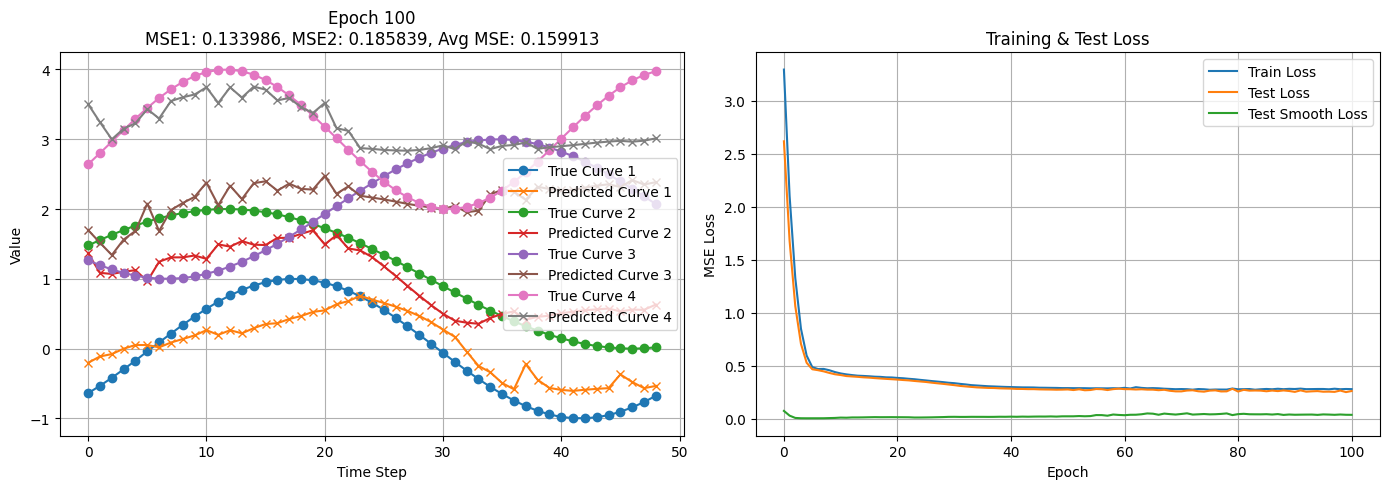

Epoch 120, Train Loss: 0.264336, Test MSE: 0.259706, Test Smooth: 0.034058


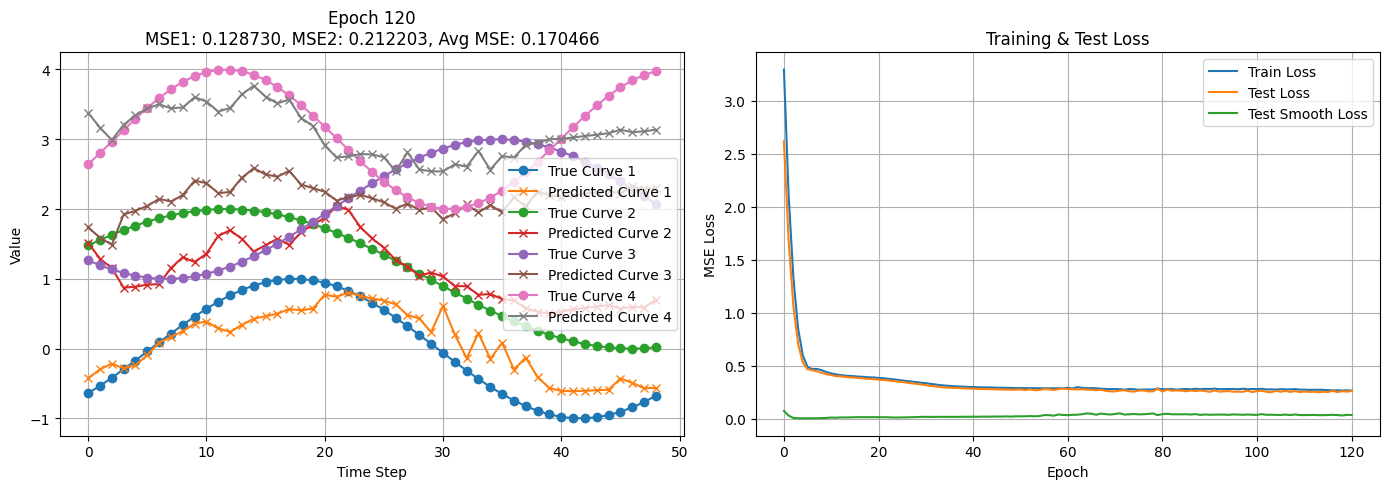

Epoch 140, Train Loss: 0.259876, Test MSE: 0.258882, Test Smooth: 0.028629


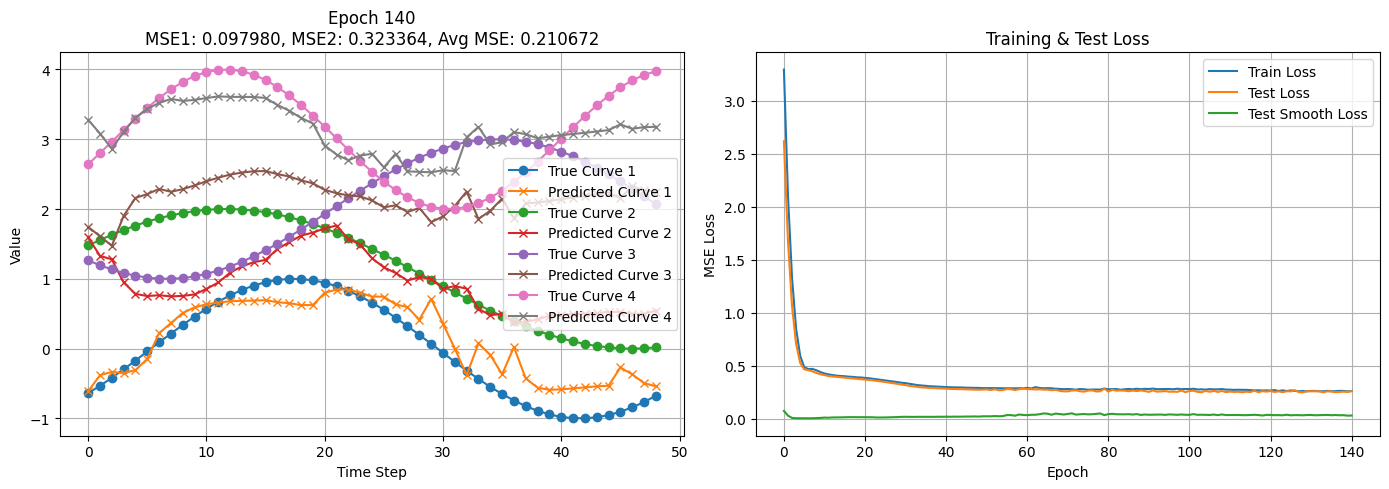

Epoch 160, Train Loss: 0.257484, Test MSE: 0.244079, Test Smooth: 0.029361


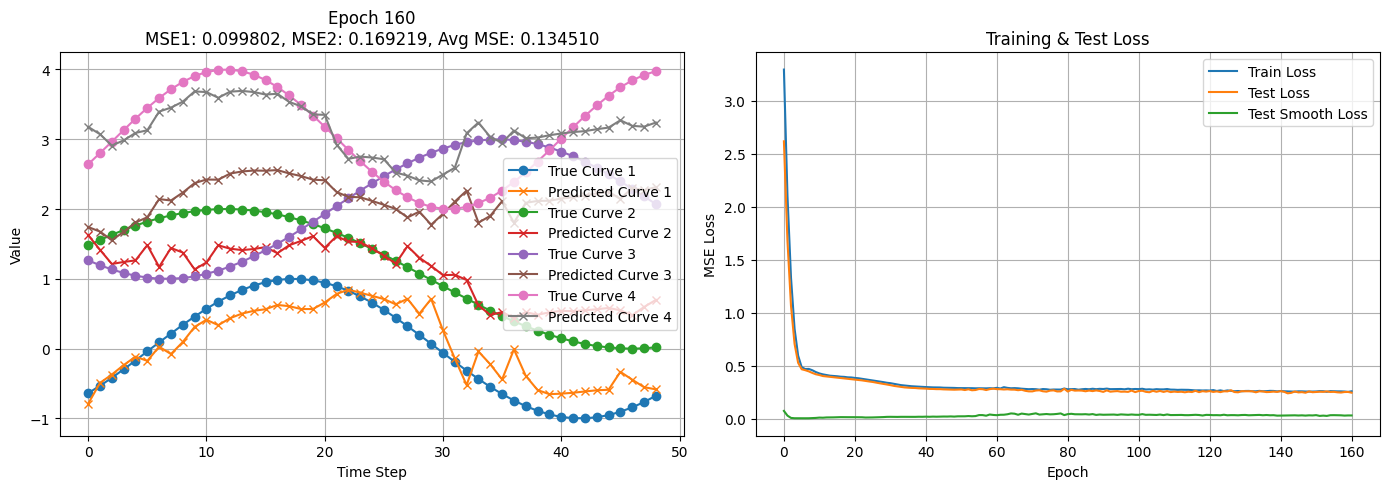

Epoch 180, Train Loss: 0.247018, Test MSE: 0.243458, Test Smooth: 0.031128


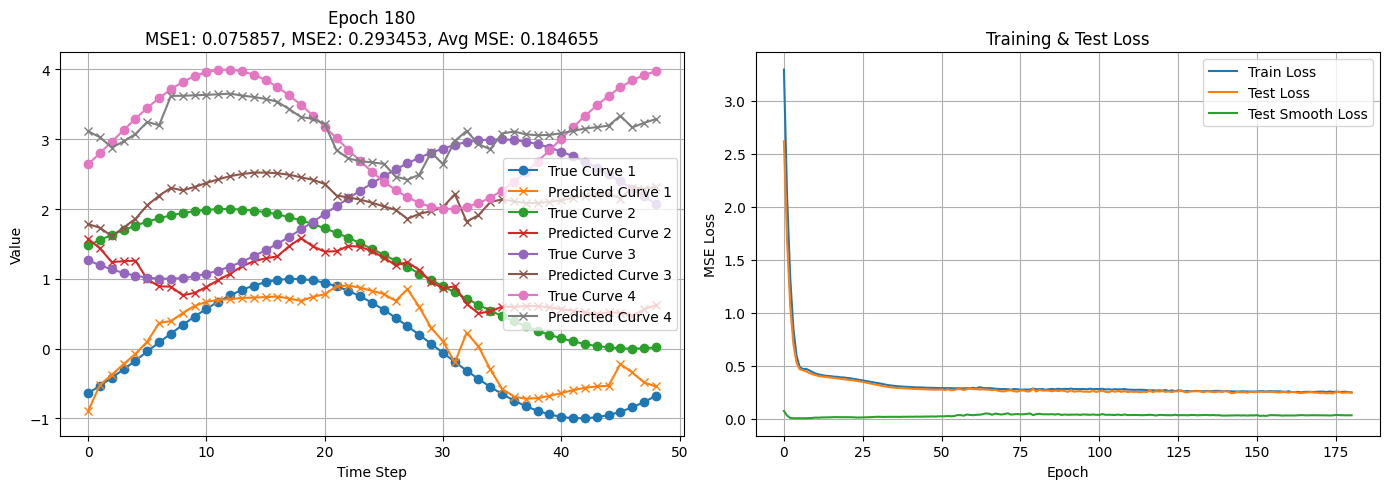

Epoch 200, Train Loss: 0.243544, Test MSE: 0.240383, Test Smooth: 0.034202


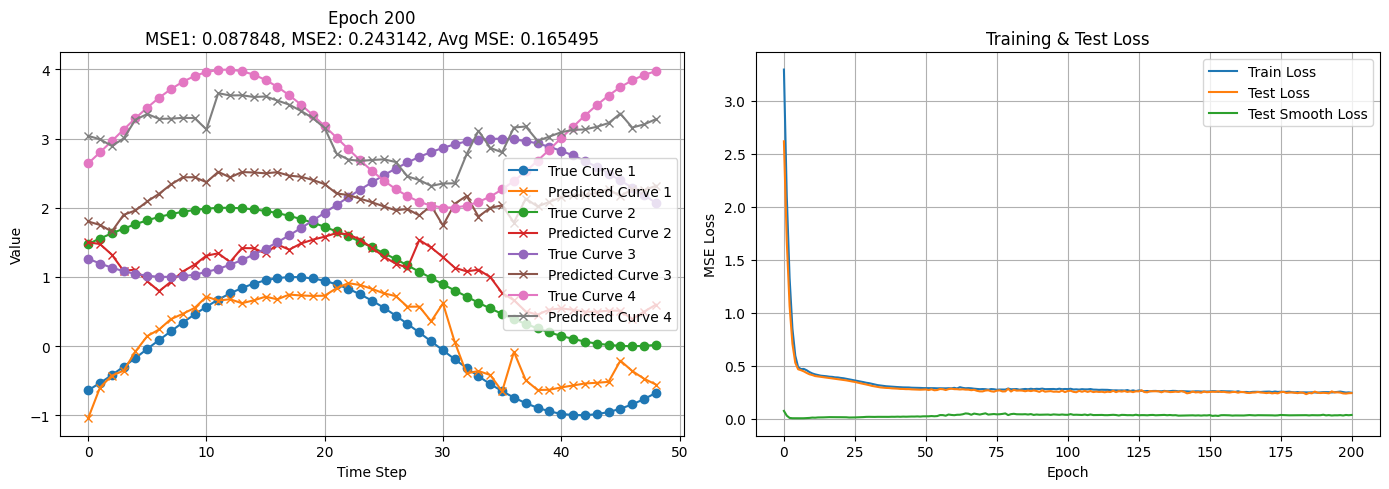

Epoch 220, Train Loss: 0.237757, Test MSE: 0.233661, Test Smooth: 0.032964


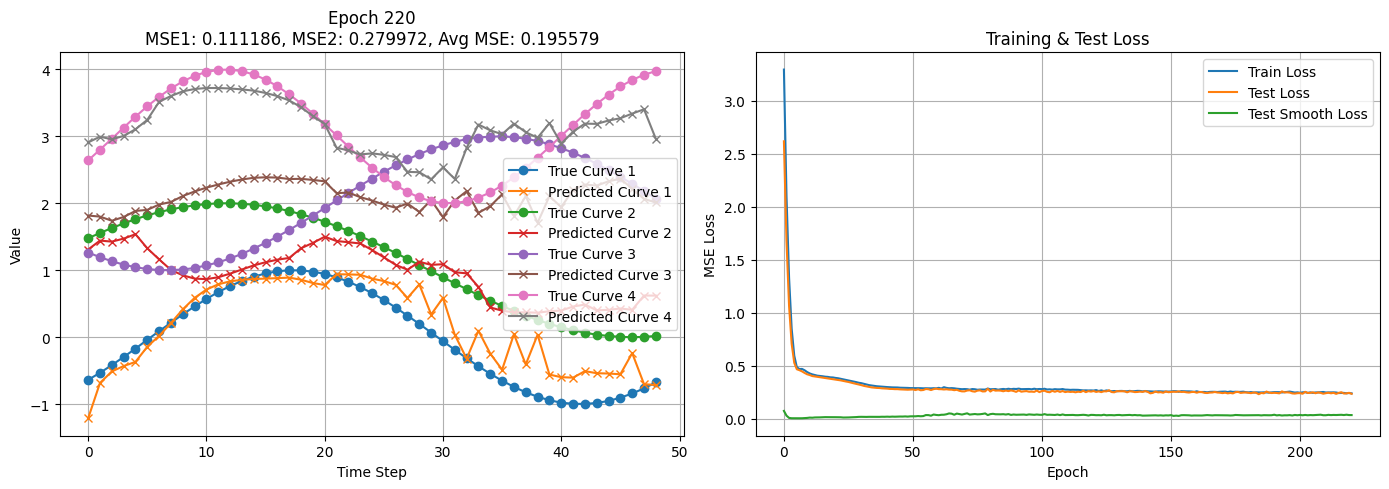

Epoch 240, Train Loss: 0.230982, Test MSE: 0.235809, Test Smooth: 0.038728


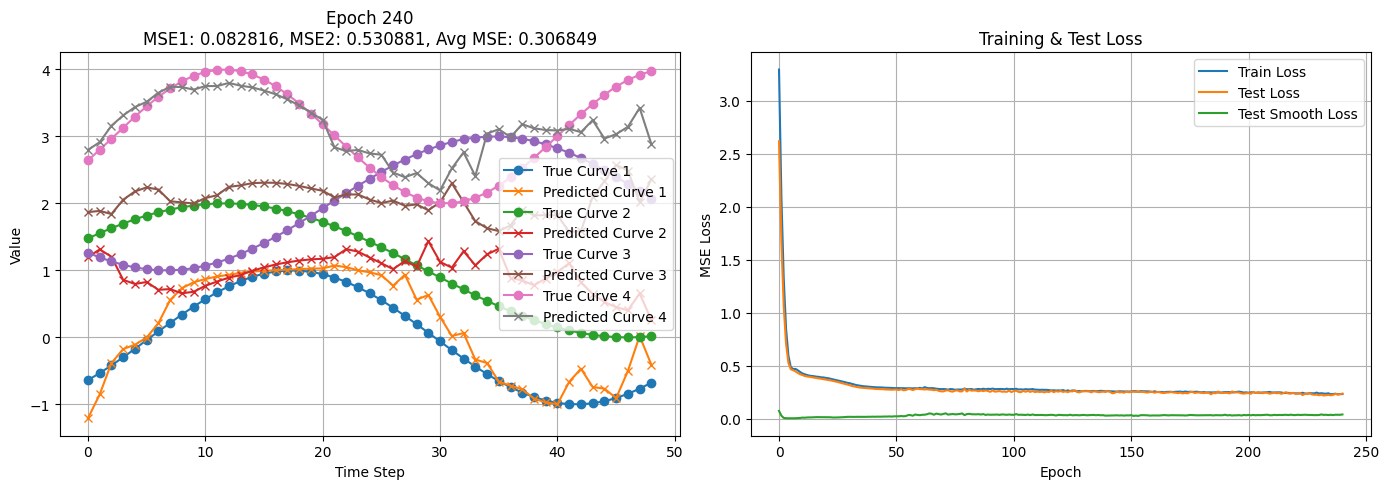

In [5]:
# -------------------------------
# Training Loop with Test Loss Evaluation
# -------------------------------
train_losses = []
test_losses = []
test_smooth_losses = []  # For tracking test smoothness loss


for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        # X_batch, Y_batch shape: (batch, seq_len, N_curves)
        current_batch_size = X_batch.size(0)
        # Initialize hidden state using the first measurement of each sample
        hidden = model.init_hidden(batch_size=current_batch_size)
        hidden[0, :, :N_curves] = X_batch[:, 1, :]
        hidden[0, :, N_curves:] = X_batch[:, 1, :]

        optimizer.zero_grad()
        predicted_positions = []  # List to store predictions per time step
        
        # Loop over time steps (t=0 ... seq_len-1)
        for t in range(X_batch.size(1)):
            current_measurement = Y_batch[:, t, :]  # shape: (batch, N_curves)
            assigned_measurements = []
            
            # Process Hungarian assignment per sample in the batch
            for b in range(current_batch_size):
                with torch.no_grad():
                    hidden_b = hidden[0, b]  # shape: (hidden_size,)
                    predicted_state = (pred_mat @ hidden_b.unsqueeze(1)).cpu().numpy()  # shape: (N_curves, 1)
                    meas_b = current_measurement[b].unsqueeze(0).cpu().numpy()  # shape: (1, N_curves)
                    cost_matrix = np.abs(predicted_state - meas_b)  # shape: (N_curves, N_curves)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    
                    assigned = np.zeros(N_curves)
                    for r, c in zip(row_ind, col_ind):
                        assigned[r] = current_measurement[b, c].item()
                    
                    assigned_measurements.append(torch.tensor(assigned, dtype=torch.float32))
            
            # Stack assigned measurements into a batch tensor: shape (batch, N_curves)
            assigned_measurement_batch = torch.stack(assigned_measurements, dim=0)
            
            # Forward pass through the RNN model
            prediction, hidden = model(assigned_measurement_batch, hidden)
            predicted_positions.append(prediction[:, :N_curves])
        
        # Stack predictions over time: shape (batch, time_steps, N_curves)
        predicted_seq = torch.stack(predicted_positions, dim=1)

        # Compute standard MSE loss between prediction and target
        mse_loss = criterion(predicted_seq, Y_batch)
        # Compute smoothness loss by penalizing large differences between consecutive time steps
        diff = predicted_seq[:, 1:, :] - predicted_seq[:, :-1, :]
        smoothness_loss = torch.mean(diff ** 2)
        # Total loss is the sum of the MSE loss and the weighted smoothness loss
        loss = mse_loss + lambda_smooth * smoothness_loss

        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # -------------------------------
    # Evaluation on Test Set
    # -------------------------------
    model.eval()
    total_test_mse = 0.0
    total_test_smooth = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            current_batch_size = X_batch.size(0)
            hidden = model.init_hidden(batch_size=current_batch_size)
            hidden[0, :, :N_curves] = X_batch[:, 1, :]
            hidden[0, :, N_curves:] = X_batch[:, 1, :]
            predicted_positions = []
            
            for t in range(X_batch.size(1)):
                current_measurement = Y_batch[:, t, :]
                assigned_measurements = []
                for b in range(current_batch_size):
                    hidden_b = hidden[0, b]
                    predicted_state = (pred_mat @ hidden_b.unsqueeze(1)).cpu().numpy()
                    meas_b = current_measurement[b].unsqueeze(0).cpu().numpy()
                    cost_matrix = np.abs(predicted_state - meas_b)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    assigned = np.zeros(N_curves)
                    for r, c in zip(row_ind, col_ind):
                        assigned[r] = current_measurement[b, c].item()
                    assigned_measurements.append(torch.tensor(assigned, dtype=torch.float32))
                assigned_measurement_batch = torch.stack(assigned_measurements, dim=0)
                prediction, hidden = model(assigned_measurement_batch, hidden)
                predicted_positions.append(prediction[:, :N_curves])
            
            predicted_seq = torch.stack(predicted_positions, dim=1)

            # For display
            sample_pred = predicted_seq[-1].detach().cpu().numpy()  # shape: (time_steps, N_curves)
            sample_target = Y_batch[-1].detach().cpu().numpy()     # shape: (time_steps, N_curves)
            
            mse_val = criterion(predicted_seq, Y_batch)
            diff_val = predicted_seq[:, 1:, :] - predicted_seq[:, :-1, :]
            smooth_val = torch.mean(diff_val ** 2)
            total_test_mse += mse_val.item()
            total_test_smooth += smooth_val.item()
            
    avg_test_mse = total_test_mse / len(test_loader)
    avg_test_smooth = total_test_smooth / len(test_loader)
    test_losses.append(avg_test_mse)
    test_smooth_losses.append(avg_test_smooth)
    
    # -------------------------------
    # Plot sample predictions and loss curves every 10 epochs
    # -------------------------------
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Test MSE: {avg_test_mse:.6f}, Test Smooth: {avg_test_smooth:.6f}")
        
        # Visualization: sample prediction from last training batch
        MSE1 = np.mean((sample_pred[:, 0] - sample_target[:, 0])**2)
        MSE2 = np.mean((sample_pred[:, 1] - sample_target[:, 1])**2)
        MSE = (MSE1 + MSE2) / 2
        
        time_steps = np.arange(0, X_batch.size(1))
        plt.figure(figsize=(14, 5))
        
        # Plot sample trajectories
        plt.subplot(1, 2, 1)
        for i in range(N_curves):
            plt.plot(time_steps, sample_target[:, i], label=f'True Curve {i+1}', marker='o')
            plt.plot(time_steps, sample_pred[:, i], label=f'Predicted Curve {i+1}', marker='x')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.title(f"Epoch {epoch}\nMSE1: {MSE1:.6f}, MSE2: {MSE2:.6f}, Avg MSE: {MSE:.6f}")
        plt.grid(True)
        
        # Plot loss curves
        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.plot(test_smooth_losses, label='Test Smooth Loss')
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.title("Training & Test Loss")
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()